In [2]:
import os
import glob
import numpy as np
import cv2
import json
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import albumentations as A
import matplotlib.pyplot as plt

In [3]:
def load_data(image_folder, annotation_folder, img_size=(512, 256)):
    image_files = glob.glob(os.path.join(image_folder, "*.jpeg"))
    images, masks = [], []

    for img_path in image_files:
        # Đọc ảnh X-quang
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        h_orig, w_orig = image.shape  # Lấy kích thước gốc của ảnh
        image = cv2.resize(image, img_size)  # Resize về kích thước mong muốn
        image = image / 255.0  # Chuẩn hóa về [0,1]

        # Đọc annotation JSON
        json_path = os.path.join(annotation_folder, os.path.basename(img_path).replace(".jpeg", ".json"))
        mask = np.zeros(img_size, dtype=np.uint8)  # Mask với kích thước mới

        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                annotation = json.load(f)

            for shape in annotation["shapes"]:
                points = np.array(shape["points"], dtype=np.float32)

                # Tính tỷ lệ thay đổi kích thước
                scale_x = img_size[0] / w_orig
                scale_y = img_size[1] / h_orig

                # Áp dụng tỷ lệ lên các điểm annotation
                points[:, 0] *= scale_x  # Resize theo chiều rộng
                points[:, 1] *= scale_y  # Resize theo chiều cao
                points = points.astype(np.int32)

                # Vẽ vùng khối u lên mask
                cv2.fillPoly(mask, [points], 1)

        # Định dạng lại mask cho TensorFlow
        mask = np.expand_dims(mask, axis=-1)  # Thêm channel (height, width, 1)
        images.append(image.reshape(*img_size, 1))
        masks.append(mask)

    return np.array(images), np.array(masks)

# Đường dẫn dữ liệu trên Kaggle
image_folder = r"C:\Users\thres\Downloads\BTXRD\images"
annotation_folder = r"C:\Users\thres\Downloads\BTXRD\Annotations"

# Kích thước mới hình chữ nhật (VD: 512x256)
img_size = (512, 256)

# Load dữ liệu với kích thước mới
X, Y = load_data(image_folder, annotation_folder, img_size=img_size)
print(f"✅ Dữ liệu đã load: X shape {X.shape}, Y shape {Y.shape}")

✅ Dữ liệu đã load: X shape (3719, 512, 256, 1), Y shape (3719, 512, 256, 1)


In [4]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập train và test (VD: 70% train, 30% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

print(f"✅ Tập train: {X_train.shape}, Tập test: {X_test.shape}")



✅ Tập train: (2603, 512, 256, 1), Tập test: (1116, 512, 256, 1)


In [5]:
# Xây dựng mô hình U-Net đơn giản

def build_seg_unet(input_shape=(512, 256, 1)):  # Cập nhật kích thước đầu vào
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)  # 256x128

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)  # 128x64

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)  # 64x32

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)  # 32x16

    # Bottleneck
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)

    u7 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)

    u8 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)

    u9 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# Xây dựng mô hình với ảnh 512x256
model = build_seg_unet(input_shape=(512, 256, 1))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 64,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 64,   │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 64,   │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 32,    │  1,179,904 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 32,    │          0 │ conv2d_transpose

 Total params: 7,846,081 (29.93 MB)

 Trainable params: 7,846,081 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# ⚡ Data Augmentation (tăng cường dữ liệu)
def augment_image(image, mask):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.Rotate(limit=20, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(p=0.1)
    ])
    
    augmented = transform(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# ⚡ Tạo batch generator có Data Augmentation
def data_generator(X, Y, batch_size=16):
    while True:
        idx = np.random.randint(0, X.shape[0], batch_size)
        batch_X, batch_Y = X[idx], Y[idx]
        
        aug_X, aug_Y = [], []
        for img, mask in zip(batch_X, batch_Y):
            img, mask = augment_image(img, mask)
            aug_X.append(img)
            aug_Y.append(mask)
        
        yield np.array(aug_X), np.array(aug_Y)

# ⚡ Callbacks tối ưu
checkpoint = ModelCheckpoint("best_seg_unet.keras", monitor="val_loss", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# ⚡ Cải thiện Optimizer (AdamW giúp regularization tốt hơn)
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)

# ⚡ Compile mô hình
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

# ⚡ Huấn luyện mô hình với Generator
batch_size = 16
epochs = 50
steps_per_epoch = len(X_train) // batch_size

history = model.fit(data_generator(X_train, Y_train, batch_size),
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    batch_size=batch_size,
                    callbacks=[checkpoint, early_stop, reduce_lr],
                    verbose=1)

# ⚡ Đánh giá mô hình sau huấn luyện
score = model.evaluate(X_test, Y_test, verbose=0)
print(f"✅ Test Loss: {score[0]:.4f}")
print(f"✅ Test Accuracy: {score[1]*100:.2f}%")


Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9936 - loss: 0.0399 - mean_io_u_4: 0.4968
Epoch 1: val_loss improved from inf to 0.03701, saving model to best_seg_unet.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 701s 4s/step - accuracy: 0.9936 - loss: 0.0399 - mean_io_u_4: 0.4968 - val_accuracy: 0.9938 - val_loss: 0.0370 - val_mean_io_u_4: 0.4969 - learning_rate: 0.0010
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9943 - loss: 0.0348 - mean_io_u_4: 0.4972
Epoch 2: val_loss did not improve from 0.03701
162/162 ━━━━━━━━━━━━━━━━━━━━ 661s 4s/step - accuracy: 0.9943 - loss: 0.0348 - mean_io_u_4: 0.4972 - val_accuracy: 0.9938 - val_loss: 0.0379 - val_mean_io_u_4: 0.4969 - learning_rate: 0.0010
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9946 - loss: 0.0332 - mean_io_u_4: 0.4973
Epoch 3: val_loss improved from 0.03701 to 0.03652, saving model to best_seg_unet.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 676s 4s/step - accuracy: 0.9946 - loss: 0.0332 - me

In [16]:
model = build_seg_unet()
model.load_weights(r"D:/NCKH/Project/Chien/Chien_BTW4/best_seg_unet.keras")
print("✅ Mô hình Seg-Unet đã được build và load weights thành công!")


✅ Mô hình Seg-Unet đã được build và load weights thành công!


In [17]:
from tensorflow.keras.models import load_model

# Load mô hình Seg-Unet đã huấn luyện
heatmodel = load_model(r"D:/NCKH/Project/Chien/Chien_BTW4/best_seg_unet.keras")

# Kiểm tra cấu trúc mô hình
heatmodel.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 64,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 64,   │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 64,   │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 32,    │  1,179,904 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 32,    │          0 │ conv2d_transpose

 Total params: 23,538,245 (89.79 MB)

 Trainable params: 7,846,081 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,692,164 (59.86 MB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 64,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 64,   │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 64,   │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 32,    │  1,179,904 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 32,    │          0 │ conv2d_transpose

 Total params: 23,538,245 (89.79 MB)

 Trainable params: 7,846,081 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,692,164 (59.86 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Cảnh báo: Không tìm thấy vùng ung thư nào trong ảnh.


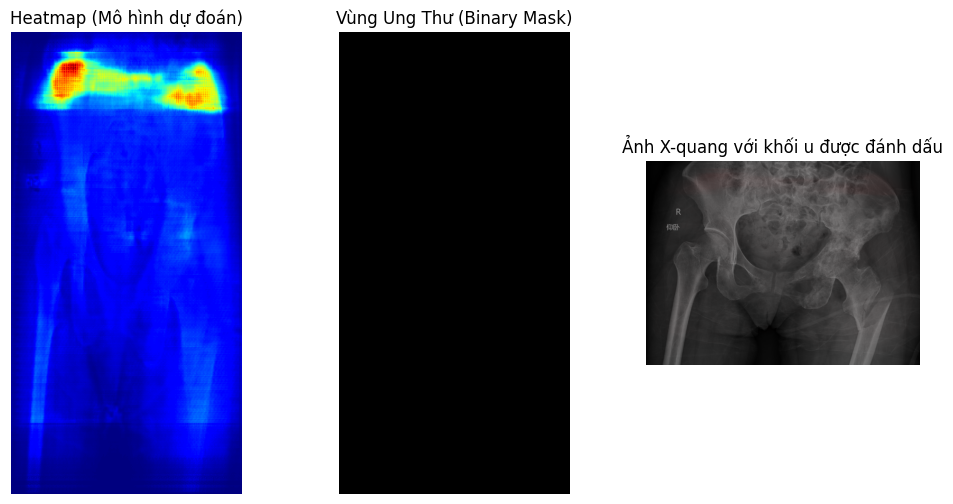

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load mô hình Seg-Unet đã huấn luyện
model_path = r"D:/NCKH/Project/Chien/Chien_BTW4/best_seg_unet.keras"
heatmodel = load_model(model_path)

# Kiểm tra cấu trúc mô hình
heatmodel.summary()

def locate(image_path):
    # Đọc ảnh X-quang grayscale
    data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Kiểm tra xem ảnh có tồn tại không
    if data is None:
        raise FileNotFoundError(f"Không tìm thấy ảnh: {image_path}")
    
    # Resize ảnh về 512x256 để phù hợp với mô hình
    data_resized = cv2.resize(data, (256, 512)) / 255.0  # Chuẩn hóa về [0,1]
    data_resized = np.expand_dims(data_resized, axis=-1)  # Thêm kênh (512,256,1)
    data_resized = np.expand_dims(data_resized, axis=0)   # Thêm batch dimension (1,512,256,1)
    
    # Dự đoán heatmap vùng ung thư
    heatmap = heatmodel.predict(data_resized)[0, :, :, 0]
    
    # Tạo mask vùng nghi ngờ ung thư (ngưỡng > 0.5)
    sel_heatmap = heatmap > 0.5
    
    # Kiểm tra nếu binary mask không có vùng nào
    if np.sum(sel_heatmap) == 0:
        print("Cảnh báo: Không tìm thấy vùng ung thư nào trong ảnh.")
    
    # Chuyển ảnh gốc sang 3 kênh để vẽ màu
    data_colored = cv2.cvtColor(data, cv2.COLOR_GRAY2BGR)
    
    # Ánh xạ heatmap lên ảnh gốc với màu xanh lá sáng hơn
    heatmap_resized = cv2.resize(heatmap, (data.shape[1], data.shape[0]))  # Resize về kích thước ảnh gốc
    heatmap_color = np.zeros_like(data_colored)
    heatmap_color[:, :, 2] = np.clip((heatmap_resized * 255 * 1.5), 0, 255).astype(np.uint8)  # Làm sáng hơn màu đỏ
    overlayed = cv2.addWeighted(data_colored, 0.6, heatmap_color, 0.7, 0)
    
    # Vẽ contour vùng nghi ngờ ung thư
    contours, _ = cv2.findContours(sel_heatmap.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlayed, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    return heatmap, sel_heatmap, overlayed

# Đường dẫn ảnh X-quang
image_path = "IMG000001.jpeg"

# Gọi hàm locate() để tìm khối u
hm, sel_hm, annotated = locate(image_path)

# Hiển thị kết quả
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Heatmap (Mô hình dự đoán)")
plt.imshow(hm, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Vùng Ung Thư (Binary Mask)")
plt.imshow(sel_hm, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Ảnh X-quang với khối u được đánh dấu")
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()
